# Realizing Velocity Prediction with CNN

This part of the notebook attempts to realize the velocity prediction with CNN as opposed to the LSTM models used in the original [paper](https://arxiv.org/pdf/1708.03535.pdf). 

In [3]:
import os
import mido
import keras
import numpy as np
import sklearn.model_selection as ms
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [4]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
set_session(session)

In [5]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

[]

###  Modeling
Now we have represented our data, we would like to see if we can build a model that predicts the velocities through the 3D matrix we generated

In [6]:
X = np.load('matricies/notes.npy')
Y = np.load('matricies/velocities.npy')
labels = np.load('matricies/labels.npy')

In [7]:
X_classical = X[(labels == 1).ravel()]
Y_classical = Y[(labels == 1).ravel()]
# X_classical = X_classical[:,:,:,1]

In [15]:
X_train, X_test, Y_train, Y_test = ms.train_test_split(X_classical, Y_classical, test_size=0.1, random_state=43)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(3750, 480, 59, 2) (417, 480, 59, 2) (3750, 480, 59) (417, 480, 59)


#### 2.1 Attempt to use a CNN of filter size (100, 1)

First we will try to use a CNN of filter size (100, 1) and see if we can correctly fit the velocity data.
The code block below will split the dataset into train and test datasets.

In [16]:
def model1(input_shape):
    X_input = keras.layers.Input(input_shape)
    X_on_off = keras.layers.Lambda(lambda X:X[:,:,:,0])(X_input)
    X_sustain = keras.layers.Lambda(lambda X:X[:,:,:,1])(X_input)
    X = X_sustain
    X = keras.layers.ZeroPadding1D((185, 0))(X)
    X = keras.layers.Conv1D(filters=input_shape[-2], kernel_size=64, dilation_rate=1, name='Conv0',
                            kernel_initializer=keras.initializers.glorot_normal(seed=None),
                            bias_initializer=keras.initializers.glorot_normal(seed=None),
                            data_format="channels_last")(X)
    X = keras.layers.BatchNormalization(axis = 2, name = 'bn0')(X)
    X = keras.layers.Conv1D(filters=input_shape[-2], kernel_size=32, dilation_rate=2, padding='valid', name='Conv1',
                            kernel_initializer=keras.initializers.glorot_normal(seed=None),
                            bias_initializer=keras.initializers.glorot_normal(seed=None),
                            data_format="channels_last")(X)
    X = keras.layers.BatchNormalization(axis = 2, name = 'bn1')(X)
    X = keras.layers.Conv1D(filters=input_shape[-2], kernel_size=16, dilation_rate=4, padding='valid', name='Conv2',
                            kernel_initializer=keras.initializers.glorot_normal(seed=None),
                            bias_initializer=keras.initializers.glorot_normal(seed=None),
                            data_format="channels_last")(X)
    X = keras.layers.BatchNormalization(axis = 2, name = 'bn2')(X)
    X = keras.layers.Activation('relu')(X)
    print(X.shape)
    print(X_on_off.shape)
    X = keras.layers.Multiply()([X, X_on_off])
#     X = keras.layers.Flatten()(X)
    model = keras.models.Model(inputs=X_input, outputs=X, name='basic')
    return model

In [17]:
m1 = model1(input_shape=X_train.shape[1:])
m1.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

(?, 480, 59)
(?, 480, 59)


In [18]:
m1.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 480, 59, 2)   0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 480, 59)      0           input_1[0][0]                    
__________________________________________________________________________________________________
zero_padding1d_1 (ZeroPadding1D (None, 665, 59)      0           lambda_2[0][0]                   
__________________________________________________________________________________________________
Conv0 (Conv1D)                  (None, 602, 59)      222843      zero_padding1d_1[0][0]           
__________________________________________________________________________________________________
bn0 (Batch

In [19]:
m1.fit(X_train, Y_train, epochs = 20, batch_size=16) # Run multiple times to train further!

Epoch 1/20
1472/3750 [==========>...................] - ETA: 30s - loss: 45.3958 - acc: 0.8096

KeyboardInterrupt: 

In [12]:
m1.save('m1_conv.h5')

In [8]:
m1 = keras.models.load_model('m1_conv.h5')

In [13]:
preds = m1.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

417/417 [==============================] - 2s 5ms/step
Loss = 3.340212339405819
Test Accuracy = 0.9335431650959902


In [14]:
Y_0_hat = m1.predict(np.expand_dims(X_test[0], axis=0))
Y_0_hat = Y_0_hat.reshape(-1, X_test.shape[-2])

In [15]:
Y_0_hat.shape

(480, 59)

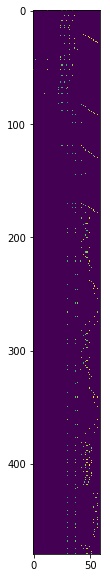

In [16]:
plt.figure(figsize = (200,10))
plt.imshow(Y_0_hat)

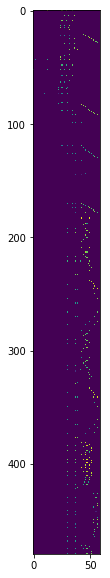

In [17]:
plt.figure(figsize = (200,10))
plt.imshow(Y_test[0].reshape(-1, X_test.shape[-2]))

It doesn't look bad!!! IM HAPPY

# Jazz

Now we need to move on to train another velocity generator for jazz. We will be using the same architecture

In [9]:
X_jazz = X[(labels == 0).ravel()]
Y_jazz = Y[(labels == 0).ravel()]
# X_classical = X_classical[:,:,:,1]

In [23]:
X_train, X_test, Y_train, Y_test = ms.train_test_split(X_jazz, Y_jazz, test_size=0.1, random_state=43)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(2580, 480, 59, 2) (287, 480, 59, 2) (2580, 480, 59) (287, 480, 59)


In [24]:
m2 = model1(input_shape=X_train.shape[1:])
m2.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

(?, 480, 59)
(?, 480, 59)


In [25]:
m2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 480, 59, 2)   0                                            
__________________________________________________________________________________________________
lambda_6 (Lambda)               (None, 480, 59)      0           input_3[0][0]                    
__________________________________________________________________________________________________
zero_padding1d_3 (ZeroPadding1D (None, 665, 59)      0           lambda_6[0][0]                   
__________________________________________________________________________________________________
Conv0 (Conv1D)                  (None, 602, 59)      222843      zero_padding1d_3[0][0]           
__________________________________________________________________________________________________
bn0 (Batch

In [26]:
m2.fit(X_train, Y_train, epochs = 50, batch_size=16) # Run multiple times to train further!

Epoch 1/50
2580/2580 [==============================] - 23s 9ms/step - loss: 27.7294 - acc: 0.8827
Epoch 2/50
2580/2580 [==============================] - 22s 9ms/step - loss: 25.5618 - acc: 0.9222
Epoch 3/50
2580/2580 [==============================] - 23s 9ms/step - loss: 23.0529 - acc: 0.9332
Epoch 4/50
2580/2580 [==============================] - 24s 9ms/step - loss: 21.0963 - acc: 0.9370
Epoch 5/50
2580/2580 [==============================] - 25s 10ms/step - loss: 19.5063 - acc: 0.9394
Epoch 6/50
2580/2580 [==============================] - 24s 9ms/step - loss: 18.1756 - acc: 0.9411
Epoch 7/50
2580/2580 [==============================] - 24s 9ms/step - loss: 17.0510 - acc: 0.9417
Epoch 8/50
2580/2580 [==============================] - 24s 9ms/step - loss: 16.1544 - acc: 0.9422
Epoch 9/50
2580/2580 [==============================] - 24s 9ms/step - loss: 15.2651 - acc: 0.9419
Epoch 10/50
2580/2580 [==============================] - 25s 10ms/step - loss: 14.4792 - acc: 0.9420
Epoch 1

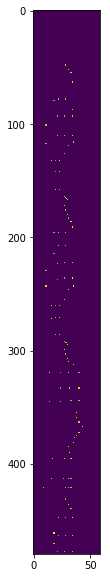

In [32]:
Y_0_hat = m1.predict(np.expand_dims(X_test[0], axis=0))
Y_0_hat = Y_0_hat.reshape(-1, X_test.shape[-2])
Y_0_hat.shape
plt.figure(figsize = (200,10))
plt.imshow(Y_0_hat)

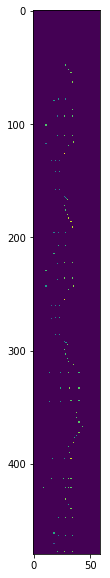

In [33]:
plt.figure(figsize = (200,10))
plt.imshow(Y_test[0].reshape(-1, X_test.shape[-2]))

# Generate

Now let us generate some music with this.

In [39]:
target_ticks_per_beat = 8
notes_to_keep_down = 32
def generate(notes_mat, velocity_mat, bpm, seconds):
    new_midi = mido.MidiFile(type=0)
    new_midi.ticks_per_beat = target_ticks_per_beat
    track = mido.MidiTrack()
    new_midi.tracks.append(track)

    track.append(mido.MetaMessage('set_tempo', tempo=mido.bpm2tempo(bpm), time=0))
    track.append(mido.MetaMessage('time_signature', numerator=4, denominator=4, 
                             clocks_per_click=24, notated_32nd_notes_per_beat=8, time=0))
    track.append(mido.MetaMessage('track_name', name='Test Track', time=0))

    T, N, D = notes_mat.shape
    notes_on = [False] * N
    prev_event_t = 0
    Ty = seconds * bpm // 60 * target_ticks_per_beat
    print('generating {0} ticks of music'.format(Ty))
    for t in range(Ty):
        for n in range(N-2):
            if notes_mat[t, n, 0] > 0:
                velocity = velocity_mat[t, n]
                track.append(mido.Message('note_on', note=n + notes_to_keep_down, velocity=velocity, time=t-prev_event_t))
                prev_event_t = t
                notes_on[n] = True
            if notes_on[n] and notes_mat[t, n, 1] == 0:
                track.append(mido.Message('note_on', note=n + notes_to_keep_down, velocity=0, time=t-prev_event_t))
                prev_event_t = t
                notes_on[n] = False
        if notes_mat[t, N-2, 0] == 1:
            track.append(mido.Message('control_change', control=64, value=127, time=t-prev_event_t))
            prev_event_t = t
            notes_on[N-2] = True
        if notes_mat[t, N-1, 0] == 1:
            track.append(mido.Message('control_change', control=67, value=127, time=t-prev_event_t))
            prev_event_t = t
            notes_on[N-2] = True
        if notes_on[N-2] and notes_mat[t, N-2, 1] == 0:
            track.append(mido.Message('control_change', control=64, value=0, time=t-prev_event_t))
            prev_event_t = t
            notes_on[N-2] = False
        if notes_on[N-1] and notes_mat[t, N-1, 1] == 0:
            track.append(mido.Message('control_change', control=67, value=0, time=t-prev_event_t))
            prev_event_t = t
            notes_on[N-1] = False
    return new_midi

In [48]:
new_midi = generate(X_test[0], np.round(Y_0_hat).astype(np.int32), 120, 30)
old_midi = generate(X_test[0], Y_test[0], 120, 30)
new_midi.save('vel_generate.midi')
old_midi.save('vel_original.midi')

generating 480 ticks of music
generating 480 ticks of music


# Cross Generate

Now let us see if music play style transfer will work by generating a velocity matrix from a jazz music with the classical music model.


In [10]:
X_classical.shape

(4167, 480, 59, 2)

In [83]:
Y_0_hat = m2.predict(np.expand_dims(X_classical[100], axis=0))
Y_0_hat = Y_0_hat.reshape(-1, X_test.shape[-2])
Y_0_hat.shape
# plt.figure(figsize = (200,10))
# plt.imshow(Y_0_hat)

(480, 59)

In [84]:
# plt.figure(figsize = (200,10))
# plt.imshow(Y_classical[100])

In [92]:
new_midi = generate(X_classical[100], np.round(Y_0_hat).astype(np.int32), 110, 30)
old_midi = generate(X_classical[100], Y_classical[100], 110, 30)
new_midi.save('vel_generate_c2j.midi')
old_midi.save('vel_original_c2j.midi')

generating 440 ticks of music
generating 440 ticks of music


In [11]:
Y_0_hat = m1.predict(np.expand_dims(X_jazz[64], axis=0))
Y_0_hat = Y_0_hat.reshape(-1, X_test.shape[-2])
Y_0_hat.shape
new_midi = generate(X_jazz[64], np.round(Y_0_hat).astype(np.int32), 110, 30)
old_midi = generate(X_jazz[64], Y_jazz[64], 110, 30)
new_midi.save('vel_generate_j2c.midi')
old_midi.save('vel_original_j2c.midi')


ValueError: Error when checking input: expected input_1 to have shape (1024, 88, 2) but got array with shape (480, 59, 2)

In [1]:
plt.figure(figsize = (200,10))
plt.imshow(Y_0_hat)

NameError: name 'plt' is not defined

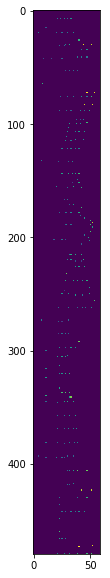

In [96]:
plt.figure(figsize = (200,10))
plt.imshow(Y_jazz[64])